In [1]:
from pathlib import Path
from tqdm.auto import tqdm
from IPython.display import clear_output

import numpy as np
from numpy import asarray, hstack, sqrt
from numpy.random import randn, randint, choice

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import keras
import visualkeras
import tensorflow as tf
import tensorflow_addons as tfa

from keras.models import Sequential, load_model
from keras.layers import Conv2D, Flatten, Dense, MaxPool2D
from keras.datasets import mnist, fashion_mnist, cifar10
from keras.optimizers import SGD, Adam
from keras.utils import to_categorical
from tqdm.keras import TqdmCallback

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import logging
tf.get_logger().setLevel(logging.ERROR)

/Users/hamzz/anaconda3/envs/tensorflow_env/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
cwd = Path.cwd()
tqdm_callback = tfa.callbacks.TQDMProgressBar()

CLASS_NAMES = {
    'mnist': ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine'],
    'fashion_mnist': ['t-shirt/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot'],
    'cifar10': ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'],
}

In [3]:
# HYPER PARAM
EPOCHS = 40
BATCH_SIZE = 128
DATASET_NAME = 'fashion_mnist'
dataset = fashion_mnist

verbose = 0
input_shape = (28, 28, 1)
opt = SGD(learning_rate=0.001, momentum=0.9)

## Data Processing

In [4]:
def load_data(dataset=mnist):
    (X_train, y_train), (X_test, y_test) = dataset.load_data()
    return (X_train, y_train), (X_test, y_test)

def data_info(data=None):
    X, y = data

    print('Shape:')
    print(f'X: {X.shape}\ty: {y.shape}')

    print('\nAbout:')
    print(f'X: {X.max()}(max)\t{X.min()}(min)\ny: {y[0]}')

# GAN IMAGE GENERATION
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    X_input = randn(latent_dim * n_samples)
    X_input = X_input.reshape(n_samples, latent_dim)
    labels = randint(0, n_classes, n_samples)
    return [X_input, labels]

## Models

In [5]:
# ----------------
# Baseline 1: VGG
# ----------------
def baseline_1():
    model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=3,
                           activation="relu",
                           input_shape=input_shape, kernel_initializer='he_uniform'),
    keras.layers.Conv2D(32, 3, activation="relu", kernel_initializer='he_uniform'),
    keras.layers.MaxPool2D(2),
        
    keras.layers.Flatten(),
    keras.layers.Dense(128, kernel_initializer='he_uniform'),
    keras.layers.Dense(10, activation="softmax"),
    ], name="baseline_1")

    return model

# ----------------
# Baseline 2: VGG
# ----------------
def baseline_2():
    model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=3,
                           activation="relu",
                           input_shape=input_shape, kernel_initializer='he_uniform'),
    keras.layers.Conv2D(32, 3, activation="relu", kernel_initializer='he_uniform'),
    keras.layers.MaxPool2D(2),

    keras.layers.Conv2D(64, 3, activation="relu", kernel_initializer='he_uniform'),
    keras.layers.Conv2D(64, 3, activation="relu", kernel_initializer='he_uniform'),
    keras.layers.MaxPool2D(2),
        
    keras.layers.Flatten(),
    keras.layers.Dense(128, kernel_initializer='he_uniform'),
    keras.layers.Dense(10, activation="softmax"),
    ], name="baseline_2")

    return model

# ----------------
# Baseline 3: VGG
# ----------------
def baseline_3():
    model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=3,
                           activation="relu",
                           input_shape=input_shape, padding='same', kernel_initializer='he_uniform'),
    keras.layers.Conv2D(32, 3, activation="relu", padding='same', kernel_initializer='he_uniform'),
    keras.layers.MaxPooling2D(2),

    keras.layers.Conv2D(64, 3, activation="relu", padding='same', kernel_initializer='he_uniform'),
    keras.layers.Conv2D(64, 3, activation="relu", padding='same', kernel_initializer='he_uniform'),
    keras.layers.MaxPooling2D(2),

    keras.layers.Conv2D(128, 3, activation="relu", padding='same', kernel_initializer='he_uniform'),
    keras.layers.Conv2D(128, 3, activation="relu", padding='same', kernel_initializer='he_uniform'),
    keras.layers.MaxPooling2D(2),
        
    keras.layers.Flatten(),
    keras.layers.Dense(128, kernel_initializer='he_uniform'),
    keras.layers.Dense(10, activation="softmax"),
    ], name="baseline_3")

    return model

# -----------------------
# Dropout Regularisation
# -----------------------
def dropout_regularisation():
    model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=3,
                           activation="relu",
                           input_shape=input_shape, padding='same', kernel_initializer='he_uniform'),
    keras.layers.Conv2D(32, 3, activation="relu", padding='same', kernel_initializer='he_uniform'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.2),

    keras.layers.Conv2D(64, 3, activation="relu", padding='same', kernel_initializer='he_uniform'),
    keras.layers.Conv2D(64, 3, activation="relu", padding='same', kernel_initializer='he_uniform'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.2),

    keras.layers.Conv2D(128, 3, activation="relu", padding='same', kernel_initializer='he_uniform'),
    keras.layers.Conv2D(128, 3, activation="relu", padding='same', kernel_initializer='he_uniform'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.2),
        
    keras.layers.Flatten(),
    keras.layers.Dense(128, kernel_initializer='he_uniform'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation="softmax"),
    ], name="dropout_regularisation")

    return model

# ------------------------------------	
# Variational Dropout Regularisation
# ------------------------------------
def variational_dropout_regularisation():
    model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=3,
                           activation="relu", padding='same',
                           input_shape=input_shape, kernel_initializer='he_uniform'),
    keras.layers.Conv2D(32, 3, activation="relu", padding='same', kernel_initializer='he_uniform'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.2),

    keras.layers.Conv2D(64, 3, activation="relu", padding='same', kernel_initializer='he_uniform'),
    keras.layers.Conv2D(64, 3, activation="relu", padding='same', kernel_initializer='he_uniform'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.3),

    keras.layers.Conv2D(128, 3, activation="relu", padding='same', kernel_initializer='he_uniform'),
    keras.layers.Conv2D(128, 3, activation="relu", padding='same', kernel_initializer='he_uniform'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.4),
        
    keras.layers.Flatten(),
    keras.layers.Dense(128, kernel_initializer='he_uniform'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax"),
    ], name="variational_dropout_regularisation")
    
    return model

# -----------
# Batch Norm
# -----------
def batch_norm():
    model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=3,
                           activation="relu", padding='same',
                           input_shape=input_shape),
    keras.layers.Conv2D(32, 3, activation="relu", padding='same'),
    keras.layers.BatchNormalization(axis=-1),
    keras.layers.MaxPooling2D(2),

    keras.layers.Conv2D(64, 3, activation="relu", padding='same'),
    keras.layers.Conv2D(64, 3, activation="relu", padding='same'),
    keras.layers.BatchNormalization(axis=-1),
    keras.layers.MaxPooling2D(2),

    keras.layers.Conv2D(128, 3, activation="relu", padding='same'),
    keras.layers.Conv2D(128, 3, activation="relu", padding='same'),
    keras.layers.BatchNormalization(axis=-1),
    keras.layers.MaxPooling2D(2),
        
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax"),
    ], name="batch_norm")

    return model

# ------------------------------------------------------------
# Variational Dropout Regularisation With Batch Normalisation
# ------------------------------------------------------------
def variational_batch_norm():
    model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=3,
                           activation="relu", padding='same',
                           input_shape=input_shape),
    keras.layers.Conv2D(32, 3, activation="relu", padding='same'),
    keras.layers.BatchNormalization(axis=-1),
    keras.layers.MaxPooling2D(2),
  
Code

from pathlib import Path
from tqdm.auto import tqdm
from IPython.display import clear_output

import numpy as np
from numpy import asarray, hstack, sqrt
from numpy.random import randn, randint, choice

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import keras
import visualkeras
import tensorflow as tf
import tensorflow_addons as tfa

from keras.models import Sequential, load_model
from keras.layers import Conv2D, Flatten, Dense, MaxPool2D
from keras.datasets import mnist, fashion_mnist, cifar10
from keras.optimizers import SGD, Adam
from keras.utils import to_categorical
from tqdm.keras import TqdmCallback

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import logging
tf.get_logger().setLevel(logging.ERROR)
/Users/hamzz/anaconda3/envs/tensorflow_env/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
cwd = Path.cwd()
tqdm_callback = tfa.callbacks.TQDMProgressBar()

CLASS_NAMES = {
    'mnist': ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine'],
    'fashion_mnist': ['t-shirt/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot'],
    'cifar10': ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'],
}
# HYPER PARAM
EPOCHS = 40
BATCH_SIZE = 128
DATASET_NAME = 'fashion_mnist'
dataset = fashion_mnist

verbose = 0
input_shape = (28, 28, 1)
opt = SGD(learning_rate=0.001, momentum=0.9)
Data Processing
def load_data(dataset=mnist):
    (X_train, y_train), (X_test, y_test) = dataset.load_data()
    return (X_train, y_train), (X_test, y_test)

def data_info(data=None):
    X, y = data

    print('Shape:')
    print(f'X: {X.shape}\ty: {y.shape}')

    print('\nAbout:')
    print(f'X: {X.max()}(max)\t{X.min()}(min)\ny: {y[0]}')

# GAN IMAGE GENERATION
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    X_input = randn(latent_dim * n_samples)
    X_input = X_input.reshape(n_samples, latent_dim)
    labels = randint(0, n_classes, n_samples)
    return [X_input, labels]
Models
  keras.layers.Dropout(0.2),

    keras.layers.Conv2D(64, 3, activation="relu", padding='same'),
    keras.layers.Conv2D(64, 3, activation="relu", padding='same'),
    keras.layers.BatchNormalization(axis=-1),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.3),

    keras.layers.Conv2D(128, 3, activation="relu", padding='same'),
    keras.layers.Conv2D(128, 3, activation="relu", padding='same'),
    keras.layers.BatchNormalization(axis=-1),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.4),
        
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax"),
    ], name="variational_batch_norm")

    return model

## Plot

### Metrics

In [6]:
def data_distribution(dataset=tf.keras.datasets.mnist.load_data(), class_names=None,
                      figsize=(10, 10), fontsize=16, save_fig=False, 
					  figname='classes_distribution'): 

    (_, y_train), (_, y_test) = dataset
    
    y_train = y_train.squeeze()
    y_test = y_test.squeeze()
    
    train_counts = np.bincount(y_train)
    test_counts = np.bincount(y_test)
    
    digits = np.arange(10)
    
    custom_params = {"axes.spines.right": False, "axes.spines.top": False}
    sns.set_theme(style="dark", rc=custom_params)
    
    plt.figure(figsize=figsize)
    plt.bar(digits, train_counts, label='Train')
    plt.bar(digits, test_counts, label='Test', bottom=train_counts)
    
    for i, count in enumerate(train_counts):
        plt.text(i, count//2, str(count), ha='center', va='bottom', color='white', 
                 fontweight='normal', rotation=90, fontsize=fontsize-3)
    
    for i, count in enumerate(train_counts):
        plt.text(i, count + 150, test_counts[i], ha='center', va='bottom', color='black', 
                 fontweight='normal', fontsize=fontsize-3, rotation=90)
    
    plt.xticks(digits)
    
    plt.title(f'Distribution of {class_names} Classes', fontsize=fontsize)
    plt.ylabel('Count', fontsize=fontsize-2)
    plt.xlabel('Class', fontsize=fontsize-2)
    
    class_names = [x.title() for x in CLASS_NAMES[class_names]]
    plt.xticks(ticks=np.arange(10), labels=class_names, fontsize=fontsize-3, rotation=45)
    plt.yticks(fontsize=fontsize-3)
    
    plt.legend(loc='lower right', fontsize=fontsize-1)
        
    plt.tight_layout()

    plt.show()

In [7]:
def metric_plot(history=None, dataset=None, fontsize=20,
               figsize=(10, 8)):

    hash = {
        'legend_loc': ['upper right', 'lower right'],
        'color': ['#1f77b4', '#ff7f0e' ],
        'text': {
            'loss': [0.90, 0.80],
            'accuracy': [0.15, 0.05]
        }
    }
    
    sns.set_theme(style='darkgrid')
    fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=figsize)
    X = np.arange(EPOCHS)
    
    for i in range(len(axs)):
        key = 'loss'
        if i == 1:
            key = 'accuracy'
        
        sns.lineplot(x=X, y=history.history[key], ax=axs[i], 
                     linewidth=2.5, label='Training', color=hash['color'][0])
        sns.lineplot(x=X, y=history.history[f'val_{key}'], ax=axs[i], 
                     linewidth=2.5, linestyle='--', label='Testing', color=hash['color'][1])
    
        axs[i].legend(loc=hash['legend_loc'][i], fontsize=fontsize)
    
        axs[i].set_ylabel(f'{key.title()}', fontsize=fontsize)
        axs[i].tick_params(axis='y', labelsize=fontsize-6)
    
        for spine in ['top', 'right']:
            axs[i].spines[spine].set_visible(False)
        
        axs[i].text(0.55, hash['text'][key][0], '{}: {:.4f}'.format(key, history.history[f"{key}"][-1]), 
                    transform=axs[i].transAxes, ha='right', fontsize=fontsize-3, color=hash['color'][0])
        axs[i].text(0.55, hash['text'][key][1], 'val_{}: {:.4f}'.format(key, history.history[f"val_{key}"][-1]), 
                    transform=axs[i].transAxes, ha='right', fontsize=fontsize-3, color=hash['color'][1])
    
        axs[0].set_title(f'Loss and Accuracy Curves ({dataset})', fontsize=fontsize)
        axs[1].set_xlabel('Epochs', fontsize=fontsize)
        
        num_ticks = 10  # Specify the desired number of ticks
        xticks = np.linspace(0, EPOCHS-1, num_ticks)
        xticklabels = ['{:d}'.format(int(tick)) for tick in xticks]
        
        axs[1].set_xticks(xticks)
        axs[1].set_xticklabels(xticklabels, fontsize=fontsize-6)
    
    plt.tight_layout()
    plt.show()

### Animation

In [8]:
def create_animation(dataset='mnist'):
    fig, axd = plt.subplot_mosaic([[f'x_{i}' for i in range(10)],
                                   ['top']*10,
                                   ['left']*10,],
                                  constrained_layout=True, figsize=(10, 10))
    
    l, n = 100, 10
    X_input, labels = generate_latent_points(l, n, n_classes=10)
    labels = asarray([i for i in range(10)])
    
    # Function to update the plot for each frame
    def update(frame):
        print(frame)
        g_model = load_model(f'models/CGAN/{dataset}/gen_model_e-{frame+1:03d}.h5')
        X = g_model.predict([X_input, labels], verbose=1)
        X = (X + 1) / 2.0
        
        axd['top'].cla()
        input = axd['top'].plot(X_input.flatten())
        
        axd['left'].cla()
        hist = axd['left'].hist(X_input.flatten(), bins=(l * n) // 10)
        
        for i in range(10):
            axd[f'x_{i}'].cla()
            image = axd[f'x_{i}'].imshow(X[i], cmap='gray_r')
            axd[f'x_{i}'].imshow(X[i], cmap='gray_r')
            # axd[f'x_{i}'].set_title(labels[i].squeeze())
            axd[f'x_{i}'].set_title(CLASS_NAMES[dataset][labels[i].squeeze()])
            axd[f'x_{i}'].axis('off')
        fig.suptitle(f'Epoch: {frame:03d}', fontsize=20)
        clear_output(wait=True)
    
    update(0)
    anim = animation.FuncAnimation(fig, update, frames=100, interval=1)
    
    Writer = animation.writers['pillow']
    writer = Writer(fps=60, metadata=dict(artist='Me'), bitrate=1800)
    
    anim.save(f'animation_{dataset}.gif', writer=writer)
    plt.show()

## Training

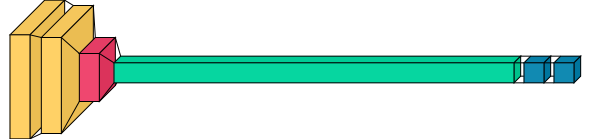

In [9]:
model = baseline_1()

visualkeras.layered_view(model)

In [10]:
(X_train, y_train), (X_test, y_test) = load_data(dataset=dataset)

X_train, X_test = X_train.astype('float32') / 255.0, X_test.astype('float32') / 255.0
X_train, X_test = np.expand_dims(X_train, axis=-1), np.expand_dims(X_test, axis=-1)
y_train, y_test = to_categorical(y_train, num_classes=10), to_categorical(y_test, num_classes=10)

model = baseline_1()
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test), 
                    batch_size=BATCH_SIZE, verbose=verbose, callbacks=[TqdmCallback(verbose=verbose)])

loss, acc = model.evaluate(X_test, y_test, verbose=0, callbacks=[tqdm_callback])
loss, acc

0epoch [00:00, ?epoch/s]

0/313           ETA: ?s - Evaluating

(0.2636374533176422, 0.9071999788284302)

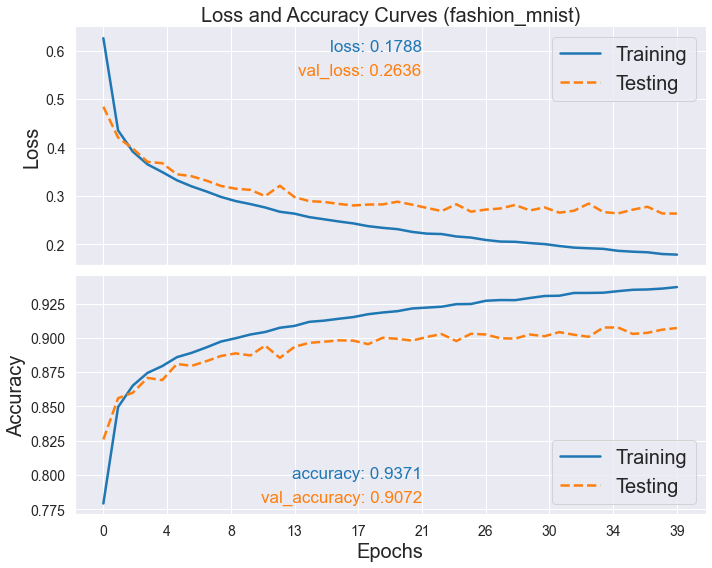

In [11]:
metric_plot(history, DATASET_NAME)

## GAN Model

In [12]:
(X_train, y_train), (X_test, y_test) = load_data(dataset=dataset)

X_train, X_test = X_train.astype('float32') / 255.0, X_test.astype('float32') / 255.0
X_train, X_test = np.expand_dims(X_train, axis=-1), np.expand_dims(X_test, axis=-1)

l, n = 100, 60000
X_input, labels = generate_latent_points(l, n, n_classes=10)

g_model = load_model(f'models/CGAN/{DATASET_NAME}/gen_model_e-{400:03d}.h5')
y = asarray([i for i in range(10) for j in range(6000)])
X = g_model.predict([X_input, y], verbose=1)
X = (X + 1) / 2.0

X_train_gan, X_test_gan, y_train_gan, y_test_gan = train_test_split(X, y, test_size=0.2, shuffle=True)

X_train_new = np.concatenate((X_train, X_train_gan), axis=0)
X_test_new  = np.concatenate((X_test, X_test_gan), axis=0)

y_train_new = np.concatenate((y_train, y_train_gan), axis=0)
y_test_new  = np.concatenate((y_test, y_test_gan), axis=0)

X_train, y_train = shuffle(X_train_new, y_train_new)
X_test, y_test = shuffle(X_test_new, y_test_new)

y_train, y_test = to_categorical(y_train, num_classes=10), to_categorical(y_test, num_classes=10)

model = baseline_1()
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test), 
                    batch_size=BATCH_SIZE, verbose=verbose, callbacks=[TqdmCallback(verbose=verbose)])

loss, acc = model.evaluate(X_test, y_test, verbose=0, callbacks=[tqdm_callback])
loss, acc

1875/1875 [==============================] - 27s 15ms/step


0epoch [00:00, ?epoch/s]

0/688           ETA: ?s - Evaluating

(0.1340859830379486, 0.9562727212905884)

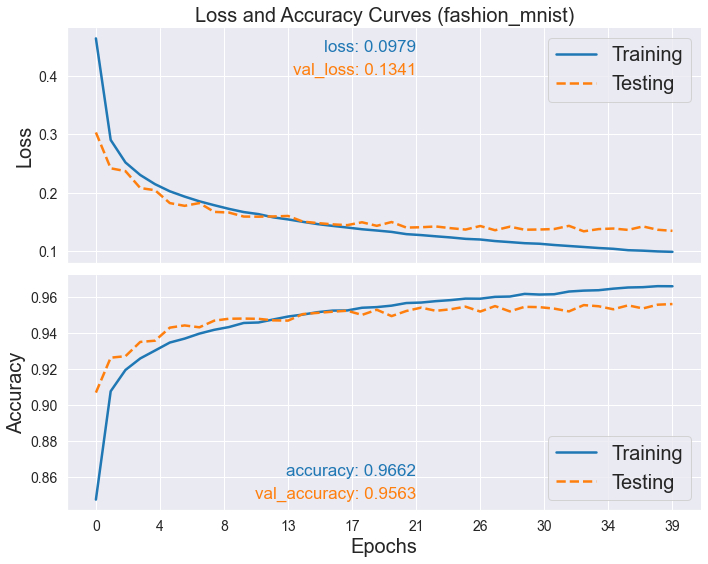

In [13]:
metric_plot(history, DATASET_NAME)